# Introduction
We have previously trained multiple machine learning models on a dataset of loan applications from 2012 and 2014. We ended the project by testing the model on a dataset of loan applications of 2015. 

The question we will now ask is: What do we do if we *only* had access to the 2015 loan applications, had no past loan applications for training for supervised machine learning models, and had no idea what the status of the 2015 loans were? We can still attempt to make sense of the unlabeled 2015 loan applications in this unsupervised learning problem, where we will divide the loans into discrete groups, or clusters. The aim is to study the characteristics of the loan applications in each cluster, so we can try to extract knowledge about the applicants without making predictions.

This will only be a basic case of unsupervised learning, where we employ k-means clustering.

# Preparing and Manipulating the Data
We will be preparing, cleaning, and manipulating the 2015 dataset. For simplicity, we will simply select the features we have previously selected in the main 2012-2015 project. We will also filter out categorical values and features with only a few discrete values. The k-means clustering algorithm works best with continuous variables.

In [1]:
import pandas as pd
import numpy as np

# Continuous variables selected from data preparation of the 2012-2014 dataset
features = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'loan_status',
            'dti', 'delinq_2yrs', 'open_acc', 'revol_bal', 'revol_util', 'total_acc', 
            'tot_coll_amt', 'tot_cur_bal', 'acc_open_past_24mths', 'avg_cur_bal', 
            'bc_util', 'delinq_amnt','mort_acc', 'num_actv_rev_tl', 'num_il_tl',
            'num_rev_accts', 'num_sats', 'pct_tl_nvr_dlq', 'tot_hi_cred_lim', 
            'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit']

Let us load the 2015 loan application dataset. We will also remove collinear features.

In [2]:
# Read raw dataset of the 2015 loan applications, skipping the header row
loans_2015 = pd.read_csv('LoanStats3d.csv', skiprows = 1)

# Filter columns so we only have the columns we have kept in the 2012-2014 dataset
# Use the DataFrame made before the categorical columns were converted into dummy columns
# One hot encoding still needs to be performed on the 2015 dataset
loans_2015 = loans_2015[features]

# Remove columns we have said were collinear in the 2012-2014 dataset
loans_2015 = loans_2015.drop(columns = ['installment', 'open_acc', 'tot_hi_cred_lim'])

loans_2015.shape

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(421097, 24)

Let us check for missing values.

In [3]:
# Check the number of missing/null values in each column. Represent as fractions out of the number of data points
null_counts = loans_2015.isnull().sum()
null_fractions = null_counts / loans_2015.shape[0]

print('Fractions:')
print(null_fractions[null_fractions > 0].sort_values(ascending = False))

Fractions:
bc_util                       0.010043
revol_util                    0.000389
dti                           0.000009
num_rev_accts                 0.000007
total_il_high_credit_limit    0.000005
tot_cur_bal                   0.000005
int_rate                      0.000005
annual_inc                    0.000005
loan_status                   0.000005
delinq_2yrs                   0.000005
revol_bal                     0.000005
total_acc                     0.000005
tot_coll_amt                  0.000005
acc_open_past_24mths          0.000005
total_bc_limit                0.000005
avg_cur_bal                   0.000005
delinq_amnt                   0.000005
mort_acc                      0.000005
num_actv_rev_tl               0.000005
num_il_tl                     0.000005
num_sats                      0.000005
pct_tl_nvr_dlq                0.000005
total_bal_ex_mort             0.000005
loan_amnt                     0.000005
dtype: float64


Quite a number of the columns have missing values. The plan is to replace missing values in the numerical columns with the feature median. We will also do the same feature engineering we did in the main project, where we convert string columns into numerical columns, like int_rate.

In [4]:
# Strip % from the int_rate and revol_util columns, convert to numbers
for c in ['int_rate', 'revol_util']:
    loans_2015[c] = loans_2015[c].str.rstrip('%').astype('float')

# Save loan_status is a separate object and remove from loans_2015 for now
status_of_loans = loans_2015['loan_status']
loans_2015.drop(columns = ['loan_status'], inplace = True)

# Check the numerical features with missing values
null_counts = loans_2015.isnull().sum()
null_fractions = null_counts / loans_2015.shape[0]
null_features = null_fractions[null_fractions > 0].index

# Replace the missing values in each column listed in null_feature with their median
for c in null_features:
    loans_2015[c] = loans_2015[c].fillna(loans_2015[c].median())

# Get new list of remaining columns. Create empty list for columns to drop
columns = loans_2015.columns
drop_columns = []

# Remove columns with one unique value
for c in columns:
    # Remove null values to make finding columns with one non-null unique value easier
    unique_column = loans_2015[c].unique()
    num_true_unique = len(unique_column)    # Number of unique values
    
    if num_true_unique == 1:
        drop_columns.append(c)
        
loans_2015.drop(columns = drop_columns, inplace =  True)

# Return loan_status to the DataFrame
loans_2015 = pd.concat((loans_2015, status_of_loans), axis = 1)

# Bring back the categorical columns.
# Drop data points with missing values in these categorical columns.
#loans_2015 = pd.concat((loans_2015, loans_categorical), axis = 1)
loans_2015.dropna(inplace = True)

# Save the loan status separately from the DataFrame
status_of_loans = loans_2015['loan_status']
loans_2015.drop(columns = ['loan_status'], inplace = True)

# See which columns still contain missing values
null_counts = loans_2015.isnull().sum()
(null_counts / loans_2015.shape[0]).sort_values(ascending = False).head()

total_il_high_credit_limit    0.0
acc_open_past_24mths          0.0
int_rate                      0.0
annual_inc                    0.0
dti                           0.0
dtype: float64

# Outlier Removal
We have dealt with the missing values in our dataset. However, let us look at the histograms of each feature. As the k-means clustering algorithm is performed by calculating Euclidean distances, outliers heavily influence the determination of the clusters. We wish to see if there are outliers present, and which features have notable outliers.

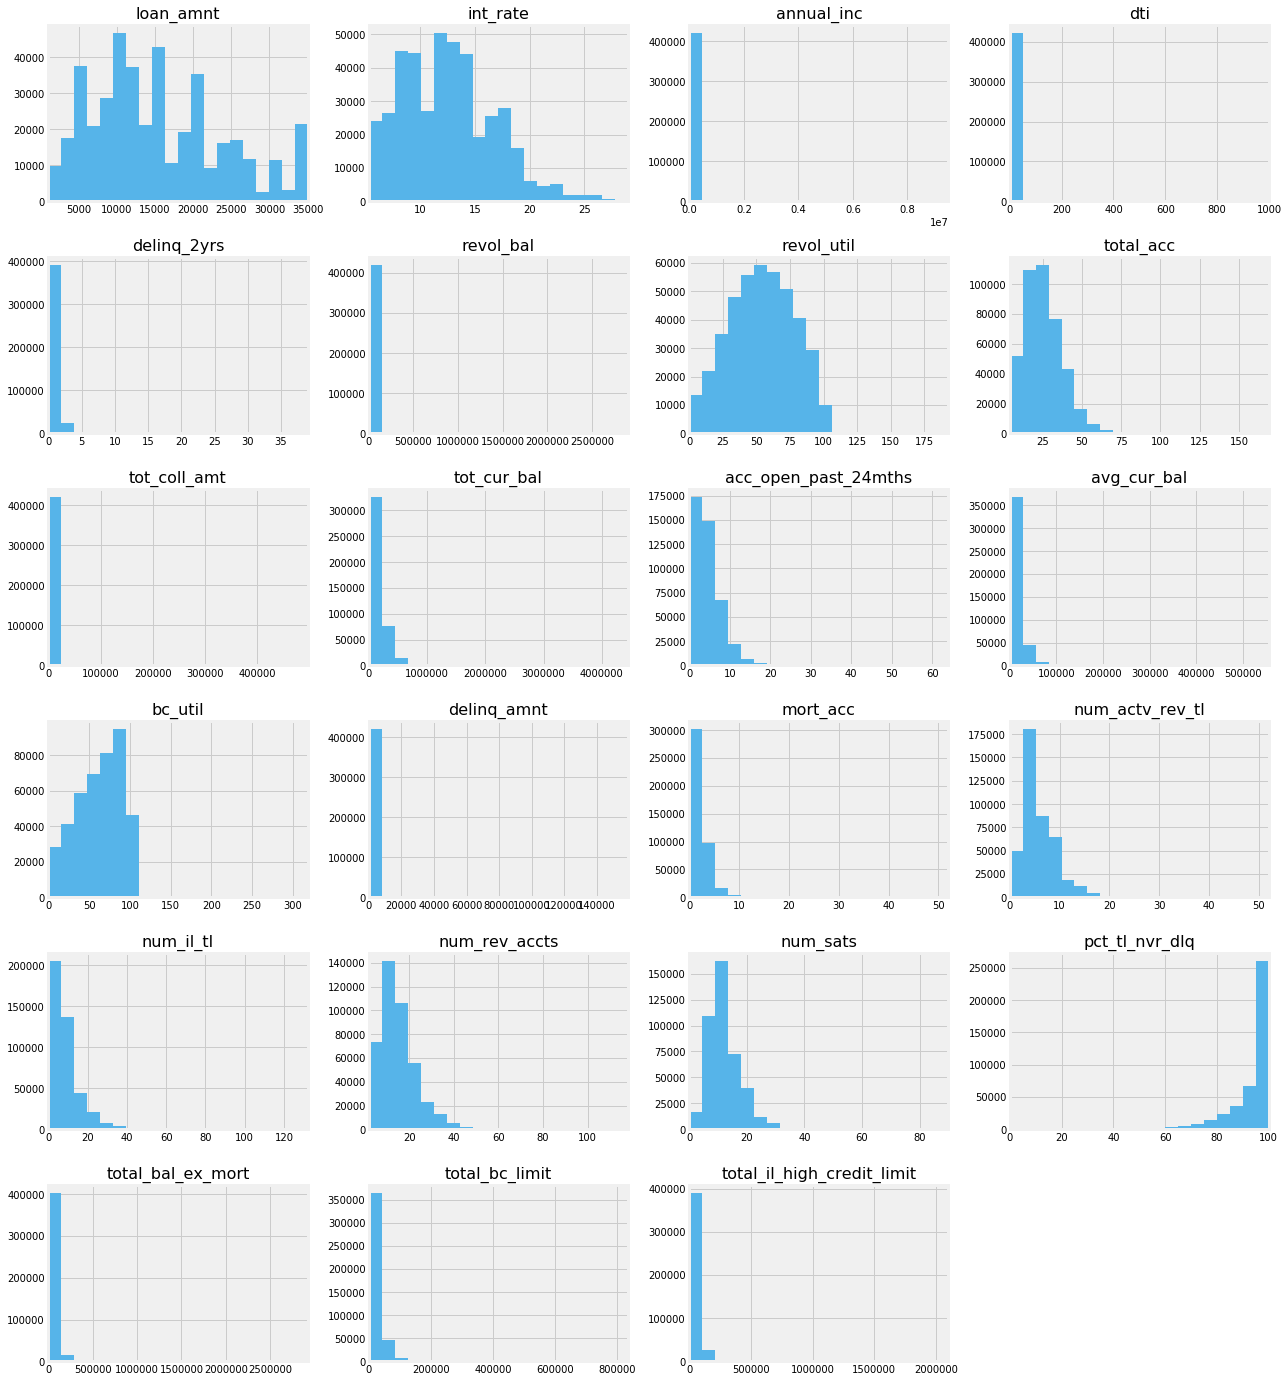

In [5]:
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')
%matplotlib inline

fig = plt.figure(figsize = (18, 32))
ax = [fig.add_subplot(10, 4,(i+1)) for i in range(loans_2015.shape[1])]

i = 0

for c in loans_2015.columns:
    loans_2015[c].hist(color = [86/255,180/255,233/255], ax = ax[i], bins = 20)
    ax[i].set_xlim([loans_2015[c].min(), loans_2015[c].max()])
    ax[i].set_title(c, fontsize = 16)
    i += 1
    
fig.tight_layout()

As a result of outliers, there are a few features with histograms that look like there is only one bin. We are interested in filtering out outliers from features that correspond to loan applicants who will very clearly pay off their loans or fail. For example, we would expect an applicant who earns at least one million dollars per year to be capable of paying off their loans. We would also expect someone with an incredibly large debt-to-income ratio to have the inability to pay off their loans, as they have proven they can't even pay off their current debts.

We will define a value to be an outlier if it is at least three standard deviations above the mean (99.7th percentile). In other words, we define a value to be an outlier if its z-score is at least 3.

In [6]:
# Specify columns with outliers we wish to remove
columns_with_outliers = ['annual_inc', 'dti', 'revol_bal', 'delinq_2yrs', 'tot_coll_amt', 'tot_cur_bal', 
                         'avg_cur_bal', 'delinq_amnt', 'total_bal_ex_mort', 
                         'total_bc_limit', 'total_il_high_credit_limit']

print(loans_2015.shape)
# Get values corresponding to the 95th percentile for the dataset variables
loans_2015['loan_status'] = status_of_loans
loans_no_outliers = loans_2015.copy()

from scipy import stats
loans_no_outliers = loans_no_outliers[(stats.zscore(loans_no_outliers[columns_with_outliers]) < 3).all(axis=1)]

# Separate loan_status column from the dataset. Dataset is once again unlabeled
status_of_loans = loans_no_outliers['loan_status']
loans_no_outliers.drop(columns = ['loan_status'], inplace = True)

loans_no_outliers.shape    

(421095, 23)


(383314, 23)

We will save the loans_status column for future analysis. However, we wish to drop this column, as our dataset needs to be unlabeled in this exercise.

# Clustering the Loan Applications
We will be employing the k-means clustering algorithm, which will involve the calculation of Euclidean distances of data points to centroids. Our features contain number with different units, ranging from dollars to percentages/ratios to numbers. It will be prudent to standardize each of our columns.

In [7]:
normalized_loans = loans_no_outliers.copy()

for c in normalized_loans.columns:
    normalized_loans[c] = (normalized_loans[c] - normalized_loans[c].mean()) / normalized_loans[c].std()

# Check for missing values, just in case
print(normalized_loans.isnull().sum().sort_values(ascending = False).head())
normalized_loans.head()

total_il_high_credit_limit    0
acc_open_past_24mths          0
int_rate                      0
annual_inc                    0
dti                           0
dtype: int64


,loan_amnt,int_rate,annual_inc,dti,delinq_2yrs,revol_bal,revol_util,total_acc,tot_coll_amt,tot_cur_bal,...,delinq_amnt,mort_acc,num_actv_rev_tl,num_il_tl,num_rev_accts,num_sats,pct_tl_nvr_dlq,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1.584887,-1.440209,0.589177,0.271799,-0.435391,2.867813,0.446124,-0.066206,-0.230406,0.867695,...,-0.034579,0.222241,0.952639,-0.617968,0.426609,0.813725,-0.300488,0.874756,1.310140,0.098834
1,0.335354,1.672298,-0.727990,-0.197105,-0.435391,-0.182568,2.049437,0.019932,-0.230406,0.119752,...,-0.034579,-0.830047,-0.836934,1.794920,-1.316286,-0.868519,0.684836,2.633395,-0.429271,2.642057
2,-0.337472,-0.443743,-0.837754,1.473073,4.528519,-0.332057,-0.531093,-0.238482,0.178305,-0.743545,...,-0.034579,-0.830047,0.654377,-0.759902,0.551102,0.813725,-0.442945,-0.421059,0.088339,-0.192495
3,2.257713,-0.443743,0.918469,-0.609136,-0.435391,1.048030,-0.091134,0.536760,-0.230406,-0.649550,...,-0.034579,-0.303903,0.952639,-0.192164,1.049072,0.439893,0.304952,-0.088495,0.810586,-0.039384
4,-0.391538,0.905785,-0.892636,0.210284,-0.435391,-0.634591,-0.603009,-1.099861,-0.230406,-0.927173,...,-0.034579,-0.830047,-0.538671,-0.901837,-0.569331,-0.494687,0.684836,-1.070759,-0.447327,-0.698402


It is now time to separate our data points into *k* clusters!

But wait! What is *k*? How many clusters *are* we separating our dataset into?

We don't know. That is up to us to find out. 

There are a few methods for finding the number of clusters. We will be going with a crude heuristic method, the "elbow method", where we try out many clusters from 1 to 20. We want to choose a number of clusters so that adding another cluster doesn't give much better modeling of the data. We will be looking at the sum of squared errors, where for each point, the error is the distance to the nearest cluster. 

K-means clustering is a stochastic process. The clustering algorithm starts by assigning random points as the centroids before the centroids are updated. For the sake of demonstration, we will set the random seed to 42.

1 14.57043808337004
2 6.531861080619115
3 5.214632451600331
4 4.604196335446044
5 3.907104507793039
6 4.424352666080929
7 4.175467927332049
8 3.5182870150722754
9 2.9586310554867414


Text(0,0.5,'SSE')

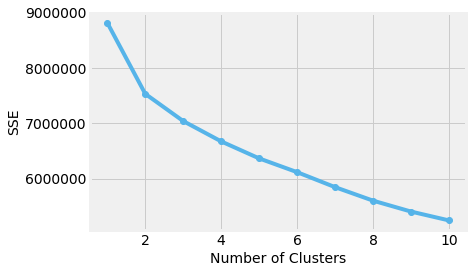

In [8]:
from sklearn.cluster import KMeans

# Create a dictionary, where the keys are the number of clusters, and values are the sum of squared errors (SSE)
sse = {}

# k: 1 to 10
for k in range(1,11):
    # Through a maximum of 1000 iterations, locate the centroid(s) of the cluster(s)
    kmeans = KMeans(n_clusters = k, max_iter=1000, random_state = 42).fit(normalized_loans)
    
    # Calculate SSE
    sse[k] = kmeans.inertia_
    
    if k > 1:
        #percent_change = np.abs(sse[k] - sse[1]) / sse[1] * 100
        percent_change = np.abs(sse[k] - sse[k-1]) / sse[k-1] * 100
        print(k-1, percent_change)

plt.plot(list(sse.keys()), list(sse.values()), '-o', color = [86/255,180/255,233/255])
plt.tick_params(labelsize = 14)
plt.xlabel('Number of Clusters', fontsize = 14)
plt.ylabel('SSE', fontsize = 14)

We see that the first time the decrease in SSE slows down when we go from 2 clusters to 3 clusters. This is seen in the figure above, where there is an angular "elbow" at 2 clusters. 

What's peculiar is that the original classification problem (will the loan applicants pay off their loans or not) was a binary classification problem. Could the separation of the loans into two cluster be an alternate method for predicting the loan status?

Now that we have determined that we wish to separate our dataset into two clusters, let us iteratively calculate our two centroids. Each data point will receive a label corresponding to their cluster assignment (i.e. which centroid the data point is closest to in terms of Euclidean distance).

In [9]:
# Determine the two cluster centroids, assign each data point to a cluster
kmeans = KMeans(n_clusters = 2, max_iter=1000, random_state = 42)
kmeans = kmeans.fit(normalized_loans)
labels = kmeans.predict(normalized_loans)
centroids = kmeans.cluster_centers_

# Add cluster labels to the DataFrame
clustered_loans = loans_no_outliers.copy()
clustered_loans['cluster'] = labels
clustered_loans.head()

,loan_amnt,int_rate,annual_inc,dti,delinq_2yrs,revol_bal,revol_util,total_acc,tot_coll_amt,tot_cur_bal,...,mort_acc,num_actv_rev_tl,num_il_tl,num_rev_accts,num_sats,pct_tl_nvr_dlq,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,cluster
0,28000.0,6.49,92000.0,21.60,0.0,51507.0,64.5,24.0,0.0,221110.0,...,2.0,9.0,4.0,18.0,16.0,91.7,74920.0,41500.0,42503.0,0
1,17600.0,19.89,44000.0,17.56,0.0,12900.0,102.4,25.0,0.0,133285.0,...,0.0,3.0,21.0,4.0,7.0,100.0,133285.0,12600.0,127033.0,0
2,12000.0,10.78,40000.0,31.95,3.0,11008.0,41.4,22.0,230.0,31915.0,...,0.0,8.0,3.0,19.0,16.0,90.5,31915.0,21200.0,32820.0,1
3,33600.0,10.78,104000.0,14.01,0.0,28475.0,51.8,31.0,0.0,42952.0,...,1.0,9.0,7.0,23.0,14.0,96.8,42952.0,33200.0,37909.0,0
4,11550.0,16.59,38000.0,21.07,0.0,7179.0,39.7,12.0,0.0,10353.0,...,0.0,4.0,2.0,10.0,9.0,100.0,10353.0,12300.0,16005.0,1


# Cluster Statistics
Now that we have our data separated into two clusters, let us dive into the characteristics of the clusters. 

Let us select a few variables which may be telling of a loan applicant's ability to pay off their loan. These variables are related to how much money they earn, their credit, their ability to pay off loans, and their interest rates, as assigned by the Lending Club. Let us see what the cluster means of these attributes are, and compare with the mean of the entire dataset (population).

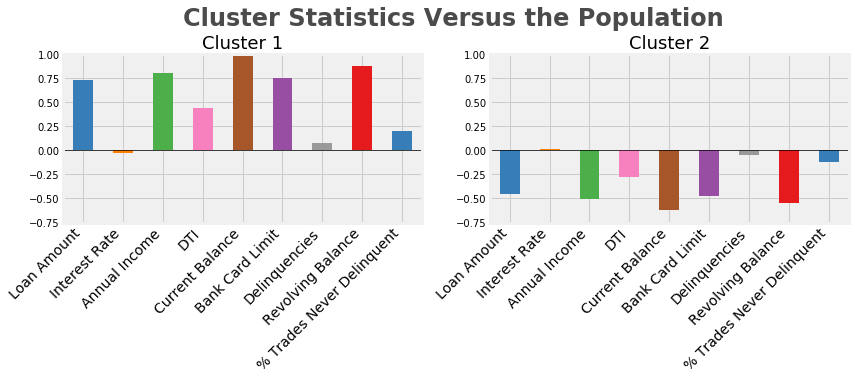

In [10]:
color_map = [[55/255,126/255,184/255], [1,127/255,0], [77/255,175/255,74/255], [247/255,129/255,191/255],
             [166/255,86/255,40/255], [152/255,78/255,163/255], [153/255,153/255,153/255],
             [228/255,26/255,28/255], [55/255,126/255,184/255], [1,127/255,0]]

fig = plt.figure(figsize = (12, 5))
ax = [fig.add_subplot(1,2,(i+1)) for i in range(len(np.unique(labels)))]

selected_features = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'tot_cur_bal', 
                     'total_bc_limit', 'delinq_2yrs', 'revol_bal' ,'pct_tl_nvr_dlq']

for i in np.unique(labels):
    cluster = clustered_loans[clustered_loans['cluster'] == i]
    
    diff_means = (cluster[selected_features].mean() - clustered_loans[selected_features].mean()) / \
                 (clustered_loans[selected_features].std() / np.sqrt(2))
    #diff_means = (cluster[selected_features].mean() - clustered_loans[selected_features].mean()) / \
    #             clustered_loans[selected_features].mean()
    
    diff_means.plot.bar(color = color_map, ax = ax[i])
    
    #ax[i].set_title('Mean: ${}, Std: ${}'.format(income_mean, income_std))
    ax[i].axhline(color = 'black', alpha = .7, lw = 1)
    ax[i].set_title('Cluster ' + str(i+1), fontsize = 18)
    #ax[i].set_ylim([-.3, .3])
    ax[i].set_ylim([-.75, 1])
    ax[i].set_xticklabels(['Loan Amount', 'Interest Rate', 'Annual Income', 'DTI',
                           'Current Balance', 'Bank Card Limit', 'Delinquencies', 
                           'Revolving Balance', '% Trades Never Delinquent'], 
                          rotation = 45, ha="right", fontsize = 14)
    #else:
    #    ax[i].set_xticklabels([])
    #annual_income.hist(ax = ax[i], color = color_map[i])
    #ax[i].set_xlim([0, 2e5])

ax[0].text(2.5, 1.3, 'Cluster Statistics Versus the Population', weight = 'bold', alpha = .7, fontsize = 24)
fig.tight_layout()

What can we learn about our two clusters from the above figure? 

We can barely see the bar, but it appears the average interest rate of cluster 1 is lower than the population mean interest rate, and the opposite can be said for cluster 2. We do not expect the average interest rates to be different between the two clusters, but perhaps this may be indicative of the probabilities of loan applicants in the clusters defaulting their loans?

What is interesting is that the loan applicants assigned to cluster 1 have many revolving trades, have high limits for their revolving credit and bank card, have higher than average debt to income ratios, and a higher than average number of delinquencies. This may indicate that these loan applicants may have trouble paying off their loans. However, these loan applicants also earn higher than average income, have higher than average current balances, and a large percentage of their trades were never delinquent.

The opposite trends are seen for cluster 2.

What is peculiar is that the applicants in the first cluster may have a large number of trades, which may account for how a large proportion of their trades were never delinquent despite the fact that they have a higher than average absolute nnumber of delinquencies in the past two years. We can confirm this by looking at distributions for the two clusters.

Descriptive statistics for Cluster 1:
Mean:  7.448422169185893
Median:  7.0
Std. Dev:  3.9281287655909116
Descriptive statistics for Cluster 2:
Mean:  4.783601769349616
Median:  4.0
Std. Dev:  2.430742716915572


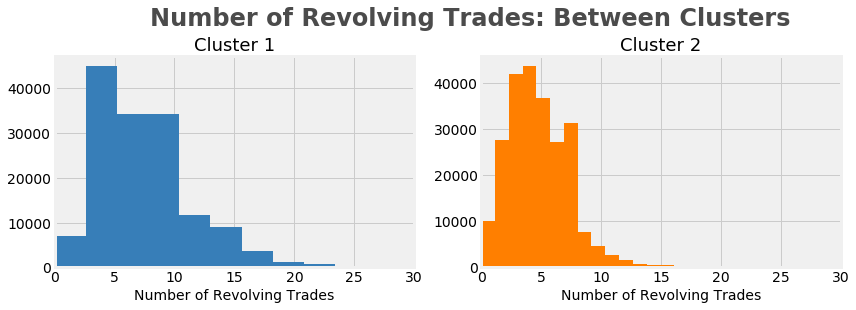

In [11]:
color_map = [[55/255,126/255,184/255], [1,127/255,0], [77/255,175/255,74/255], [247/255,129/255,191/255],
             [166/255,86/255,40/255], [152/255,78/255,163/255], [153/255,153/255,153/255],
             [228/255,26/255,28/255], [55/255,126/255,184/255], [1,127/255,0]]

fig = plt.figure(figsize = (12, 4))
ax = [fig.add_subplot(1,2,(i+1)) for i in range(len(np.unique(labels)))]

for i in np.unique(labels):
    cluster = clustered_loans[clustered_loans['cluster'] == i]
    
    revl_trades = cluster['num_actv_rev_tl']
    print('Descriptive statistics for Cluster ' + str(i+1) + ':')
    print('Mean: ', revl_trades.mean())
    print('Median: ', revl_trades.median())
    print('Std. Dev: ', revl_trades.std())
    
    #ax[i].set_title('Mean: ${}, Std: ${}'.format(income_mean, income_std))
    ax[i].set_title('Cluster ' + str(i+1), fontsize = 18)
    revl_trades.hist(ax = ax[i], color = color_map[i], bins = 20)
    ax[i].set_xlim([0, 30])
    ax[i].set_xlabel('Number of Revolving Trades', fontsize = 14)
    ax[i].tick_params(labelsize = 14)

ax[0].text(8, 54000, 'Number of Revolving Trades: Between Clusters', weight = 'bold', alpha = .7, fontsize = 24)
fig.tight_layout()

Indeed, the mean and median number of revolving trades for the loan applicants in cluster 1 is higher than for the loan applicants in cluster 2. Many loan applicants in both clusters have 4-5 revolving trades, but many more borrowers in cluster 1 have greater numbers of revolvign trades than in cluster 2. This would explain the discrepancy between the higher value for the absolute number of delinquencies and lower proportion of delinquencies for cluster 1.

Do the trends in the bar chart above imply that the loan applicants in cluster 1 earn more money, but also end up being less responsible with their money? The assigned interest rate may imply that the applicants' wealth may be a major predicting factor towards whether or not the borrowers will pay off their loans or default.

We can explore a few of the variables between the two clusters. Let's start by exploring the distributions of annual income.

Descriptive statistics for Cluster 1:
Mean:  91241.87808280457
Median:  83000.0
Std. Dev:  39478.80669389866
Descriptive statistics for Cluster 2:
Mean:  57635.136559207385
Median:  52000.0
Std. Dev:  27407.05566555616


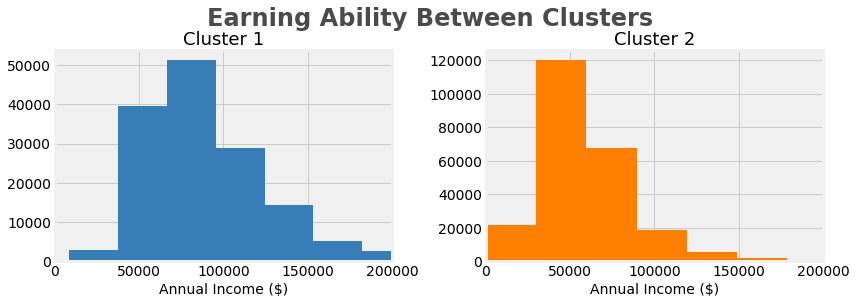

In [12]:
color_map = [[55/255,126/255,184/255], [1,127/255,0], [77/255,175/255,74/255], [247/255,129/255,191/255],
             [166/255,86/255,40/255], [152/255,78/255,163/255], [153/255,153/255,153/255],
             [228/255,26/255,28/255], [55/255,126/255,184/255], [1,127/255,0]]

fig = plt.figure(figsize = (12, 4))
ax = [fig.add_subplot(1,2,(i+1)) for i in range(len(np.unique(labels)))]

for i in np.unique(labels):
    cluster = clustered_loans[clustered_loans['cluster'] == i]
    
    annual_income = cluster['annual_inc']
    print('Descriptive statistics for Cluster ' + str(i+1) + ':')
    print('Mean: ', annual_income.mean())
    print('Median: ', annual_income.median())
    print('Std. Dev: ', annual_income.std())
    
    #ax[i].set_title('Mean: ${}, Std: ${}'.format(income_mean, income_std))
    ax[i].set_title('Cluster ' + str(i+1), fontsize = 18)
    annual_income.hist(ax = ax[i], color = color_map[i])
    ax[i].set_xlim([0, 2e5])
    ax[i].set_xticks([0, 50000, 100000, 150000, 200000])
    ax[i].tick_params(labelsize = 14)
    ax[i].set_xlabel('Annual Income ($)', fontsize = 14)

ax[0].text(90000, 60000, 'Earning Ability Between Clusters', weight = 'bold', alpha = .7, fontsize = 24)
fig.tight_layout()

We can see that the annual income histograms for cluster 1 and 2 peak at roughly \$75000 and \$50000, respectively. We can also see from the means and medians that the borrowers in cluster 1 earn more income than those in cluster 2.

What might be interesting is seeing if there is a relationship between the annual income of the loan applicants in each cluster and other variables. Let us start with examining the annual income versus the debt-to-income ratio.

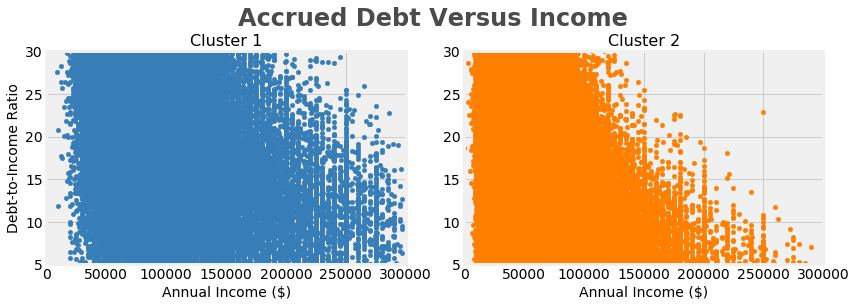

In [13]:
fig = plt.figure(figsize = (12, 4))
ax = [fig.add_subplot(1,2,(i+1)) for i in range(len(np.unique(labels)))]

max_income = 0

for i in np.unique(labels):
    cluster = clustered_loans[clustered_loans['cluster'] == i]
    #max_income = max(max_income, cluster['annual_inc'].quantile(q = .99))
    
    cluster.plot.scatter(x = 'annual_inc', y = 'dti', color = color_map[i], ax = ax[i])
    ax[i].set_title('Cluster ' + str(i+1), fontsize = 16)
    ax[i].set_xlabel('Annual Income ($)', fontsize = 14)
    ax[i].set_ylim([5,30])
    ax[i].set_xlim([0, 300000])
    ax[i].tick_params(labelsize = 14)

ax[0].set_ylabel('Debt-to-Income Ratio', fontsize = 14)  
ax[1].set_ylabel('')
ax[0].text(160000, 33, 'Accrued Debt Versus Income', weight = 'bold', alpha = .7, fontsize = 24)
fig.tight_layout()

What is intriguing is that the negative trend between the debt-to-income ratio and the annual income earned is clearer for cluster 2 than for cluster 1. What this means is that borrowers with high annual income in cluster 2 are more than likely to have low debt. This cannot be said for cluster 1.

Let us examine the relationship between the annual income and the interest rate assigned by Lending Club.

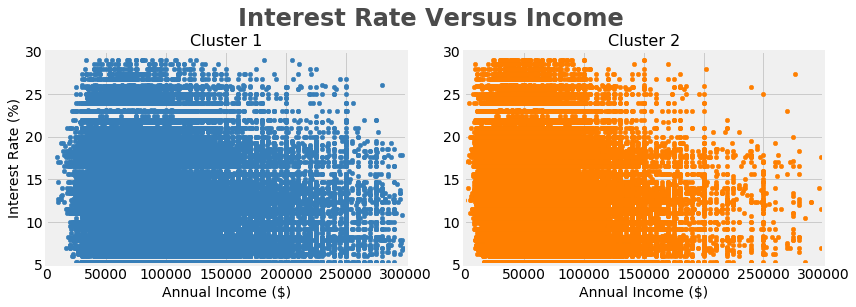

In [14]:
fig = plt.figure(figsize = (12, 4))
ax = [fig.add_subplot(1,2,(i+1)) for i in range(len(np.unique(labels)))]

max_income = 0

for i in np.unique(labels):
    cluster = clustered_loans[clustered_loans['cluster'] == i]
    #max_income = max(max_income, cluster['annual_inc'].quantile(q = .99))
    
    cluster.plot.scatter(x = 'annual_inc', y = 'int_rate', color = color_map[i], ax = ax[i])
    ax[i].set_title('Cluster ' + str(i+1), fontsize = 16)
    ax[i].set_xlim([0, 300000])
    ax[i].set_ylim([5, 30])
    ax[i].set_xlabel('Annual Income ($)', fontsize = 14)
    ax[i].tick_params(labelsize = 14)

ax[0].set_ylabel('Interest Rate (%)', fontsize = 14)
ax[1].set_ylabel('')
ax[0].text(160000, 33, 'Interest Rate Versus Income', weight = 'bold', alpha = .7, fontsize = 24)
fig.tight_layout()

We can see a negative trend between the interest rate and annual income. One of the factors towards the interest rate assigned to a borrower is the probability of default. The higher the probability, the higher the interest rate. Those with higher incomes are more likely to pay off their loans on time.

That said, this trend is slightly clearer in cluster 2 than in cluster 1. The greater amount of scatter in the interest rate at higher values is a contributing factor to the higher than average interest rate in cluster 1. 

# Can K-Means Clustering Predict Loan Defaults?
We have happened to separate our unlabeled dataset of loan applications from 2015 into two clusters. The original data science problem was predicting whether or not borrowers would pay off their loans or default. In other words, the original prediction problem was a binary classification problem. Since we have separated our data into two clusters, can this separation be our binary classification? 

Let us bring back the loan_status target column (the labels we were never meant to know about in this unsupervised learning problem) and compare the loan_status with the cluster label. If the k-means clustering algorithm is an effective method of performing binary classification, then one cluster should have a high percentage of loan applicants paying off their loans, and the other cluster should have a higher percentage of loan applicants charging off their loans.

For this comparison, we will only verify the clusters against the labels "Fully Paid" and "Charged Off". We will also hypothesize that Cluster 1 is composed of applicants who are likely to pay off their loans, and Cluster 2 is composed of applicants who are likely to charge off their loans. This is based on the average interest rates in these clusters.

In [15]:
# Create a duplicate of the clustered_loans DataFrame. Add the loan_status labels
labeled_clusters = clustered_loans.copy()
labeled_clusters['loan_status'] = status_of_loans

for label in np.unique(labels):
    # In each cluster, filter the loan applicants whose status is either "Fully Paid" or "Charged Off"
    cluster = labeled_clusters[labeled_clusters['cluster'] == label]
    cluster = cluster[(cluster['loan_status'] == 'Fully Paid') | (cluster['loan_status'] == 'Charged Off')]
    
    # Calculate the proportions of borrowers who pay off/charge off their loans in each cluster
    paid_off = cluster[cluster['loan_status'] == 'Fully Paid'].shape[0] / float(cluster.shape[0]) * 100
    charged_off = cluster[cluster['loan_status'] == 'Charged Off'].shape[0] / float(cluster.shape[0]) * 100
    
    print('Cluster #', (label + 1))
    print('Paid Off: ', paid_off, '%')
    print('Charged Off: ', charged_off, '%')

Cluster # 1
Paid Off:  77.80532128868344 %
Charged Off:  22.19467871131656 %
Cluster # 2
Paid Off:  78.3007748039416 %
Charged Off:  21.6992251960584 %


The percentages of loan applicants who successfully pay off their loans and default on their loans are roughly the same in each cluster. Let us see what the true and false positive rates are. Before we do so, we will code the "Fully Paid" status as 0 and the "Charged Off" status as 1. This is based on how Cluster 1's label is 0, and Cluster 2's label is 1.

In [16]:
mapping_dict = {
    "loan_status": {
        "Fully Paid": 0,
        "Charged Off": 1
    }
}

labeled_clusters = labeled_clusters[(labeled_clusters['loan_status'] == 'Fully Paid') | (labeled_clusters['loan_status'] == 'Charged Off')]
labeled_clusters = labeled_clusters.replace(mapping_dict)

from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(labeled_clusters['loan_status'], labeled_clusters['cluster']).ravel()

fpr = fp / (fp + tn)
tpr = tp / (tp + fn)

print('False Positive Rate: ', fpr)
print('True Positive Rate: ', tpr)

False Positive Rate:  0.6288989030686308
True Positive Rate:  0.6221237608891559


If we use k-means clustering as a classification method, we will correctly predict that some loan applicants will pay off their loans, but in exchange, we will also incorrectly predict that some borrowers will pay off their loans when they end up defaulting on their loans.

What went wrong? Well, this clustering never took the class imbalance into account (i.e. a majority of the loan applicants successfully pay off their loans, and only a minority fail to do so). We have also disregarded so many variables, especially the categorical variables that may provide additional insight, such as employment length, home ownership, and the loaning terms (36 months vs 60 months).

K-means clustering was never intended to be a classification algorithm in this case. All it does is divide our dataset into separate groups separated by linear boundaries (i.e. if there were only two variables, the clusters would be separated by a line). We could have divided our dataset into many more clusters, but this would have done nothing towards classification. We could have employed a different clustering algorithm that separate our data with nonlinear boundaries (like DBSCAN, for instance), but we should *not* expect to make predictions from this unsupervised learning problem. When we were predicting whether or not loan applicants would pay off their loans, we employed decision trees that were trained on labeled data points. The classification of the loan applicants is ultimately more complex than dividing our data points with linear boundaries.

This clustering algorithm was meant to allow us to analyze the statistics of certain groups in our data. What appears to have happened is that the clustering algorithm divided our data partially by magnitude of variable values (i.e. group loan applicants with high income and interest rates and debt-to-income ratios). 